In [1]:
import numpy as np
import pyvista as pv
from matplotlib import pyplot as plt
import pandas as pd


In [2]:
df = pd.read_csv('../data/FEM/random/random_params.csv')
df


,r0,r1,h0,h1,bevel,pocket_r,neck_x,neck_r,neck_h,neck_dh
0,0.002468,0.002877,0.000995,0.002249,0.000107,0.000827,0.001706,0.001199,0.002447,0.000042
1,0.002360,0.002947,0.000981,0.002108,0.000126,0.000844,0.001710,0.001199,0.002460,0.000060
2,0.002180,0.002894,0.000988,0.002051,0.000197,0.000821,0.001700,0.001199,0.002501,0.000112
3,0.002360,0.002875,0.000871,0.001968,0.000097,0.000842,0.001708,0.001208,0.002437,0.000089
4,0.002280,0.002755,0.000816,0.002230,0.000087,0.000834,0.001692,0.001205,0.002396,0.000032
...,...,...,...,...,...,...,...,...,...,...
95,0.002287,0.002866,0.001023,0.002073,0.000126,0.000843,0.001706,0.001195,0.002528,0.000072
96,0.002326,0.002913,0.000950,0.002155,0.000108,0.000839,0.001700,0.001210,0.002473,0.000072
97,0.002306,0.002915,0.000945,0.002193,0.000163,0.000836,0.001697,0.001194,0.002445,0.000047
98,0.002374,0.002840,0.000906,0.002171,0.000079,0.000846,0.001697,0.001205,0.002496,0.000062


In [3]:
read_mesh = lambda i: pv.read(f'../data/FEM/random/FEM2_{i}.vtu')

mesh0 = read_mesh(0)
mises0 = mesh0.point_data['von_mises_stress']
deform0 = mesh0.point_data['deformation']

mises_max = np.argmax(mises0)
deform_max = np.argmax(np.linalg.norm(deform0, axis=1))

mises_max, deform_max


(4595, 4501)

In [4]:
n = len(df)
m = len(mesh0.points)

mises_array = np.zeros([n,m])
deform_array = np.zeros([n,m,3])

for i in range(n):
    mesh = read_mesh(i)
    mises_array[i] = mesh.point_data['von_mises_stress']
    deform_array[i] = mesh.point_data['deformation']


In [5]:
mises_array.shape, deform_array.shape

((100, 9086), (100, 9086, 3))

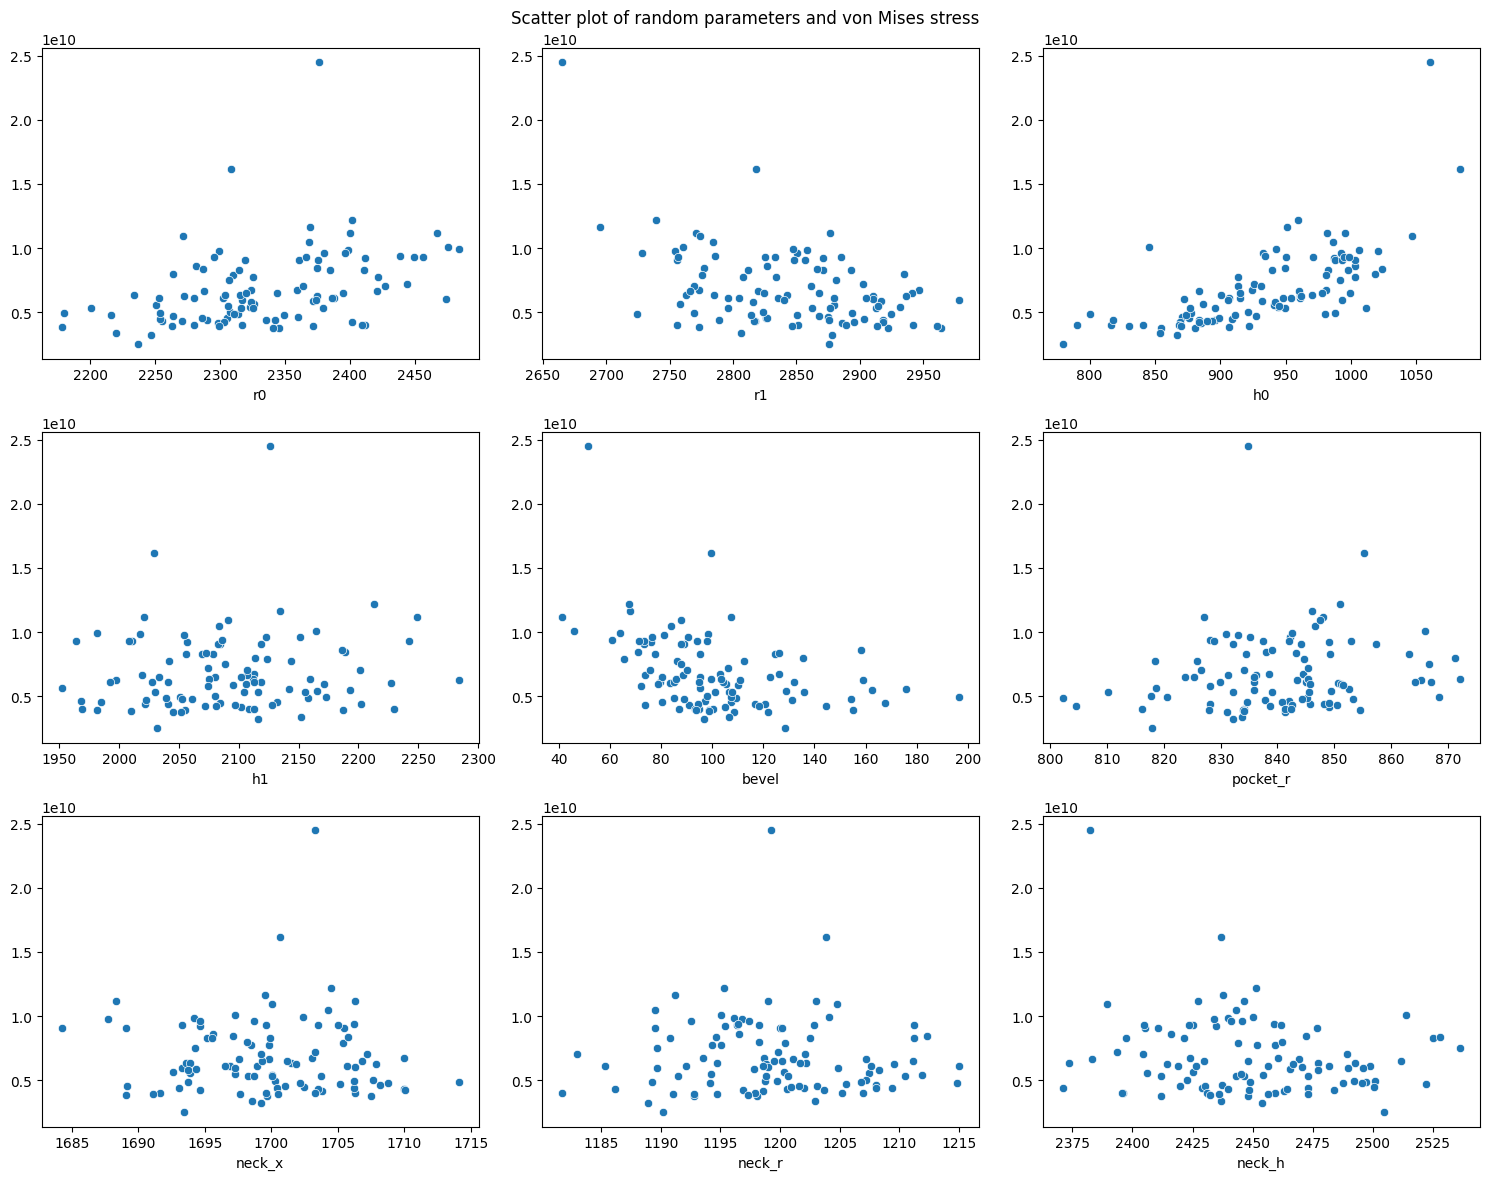

In [7]:
import seaborn as sns

# 3x3のグリッドでプロットを作成
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, ax in enumerate(axes.flat):
    x = df.iloc[:,i] * 1e6
    sns.scatterplot(x=x, y=mises_array.T[mises_max], ax=ax)

# タイトルと余白の調整
fig.suptitle('Scatter plot of random parameters and von Mises stress')
plt.tight_layout()
plt.show()

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
x = np.array(df.iloc[:,:])
y = mises_array[:,mises_max]
x.shape, y.shape

((100, 10), (100,))

In [10]:
x_with_bias = np.c_[x, np.ones(x.shape[0])]
model = LinearRegression(fit_intercept=False)


In [11]:
model.fit(x_with_bias, y)
predicted_params = model.coef_

predicted_params.shape

(11,)

In [12]:
y_predict = model.predict(x_with_bias)

In [13]:
np.vstack([x,x]).T.shape

(10, 200)

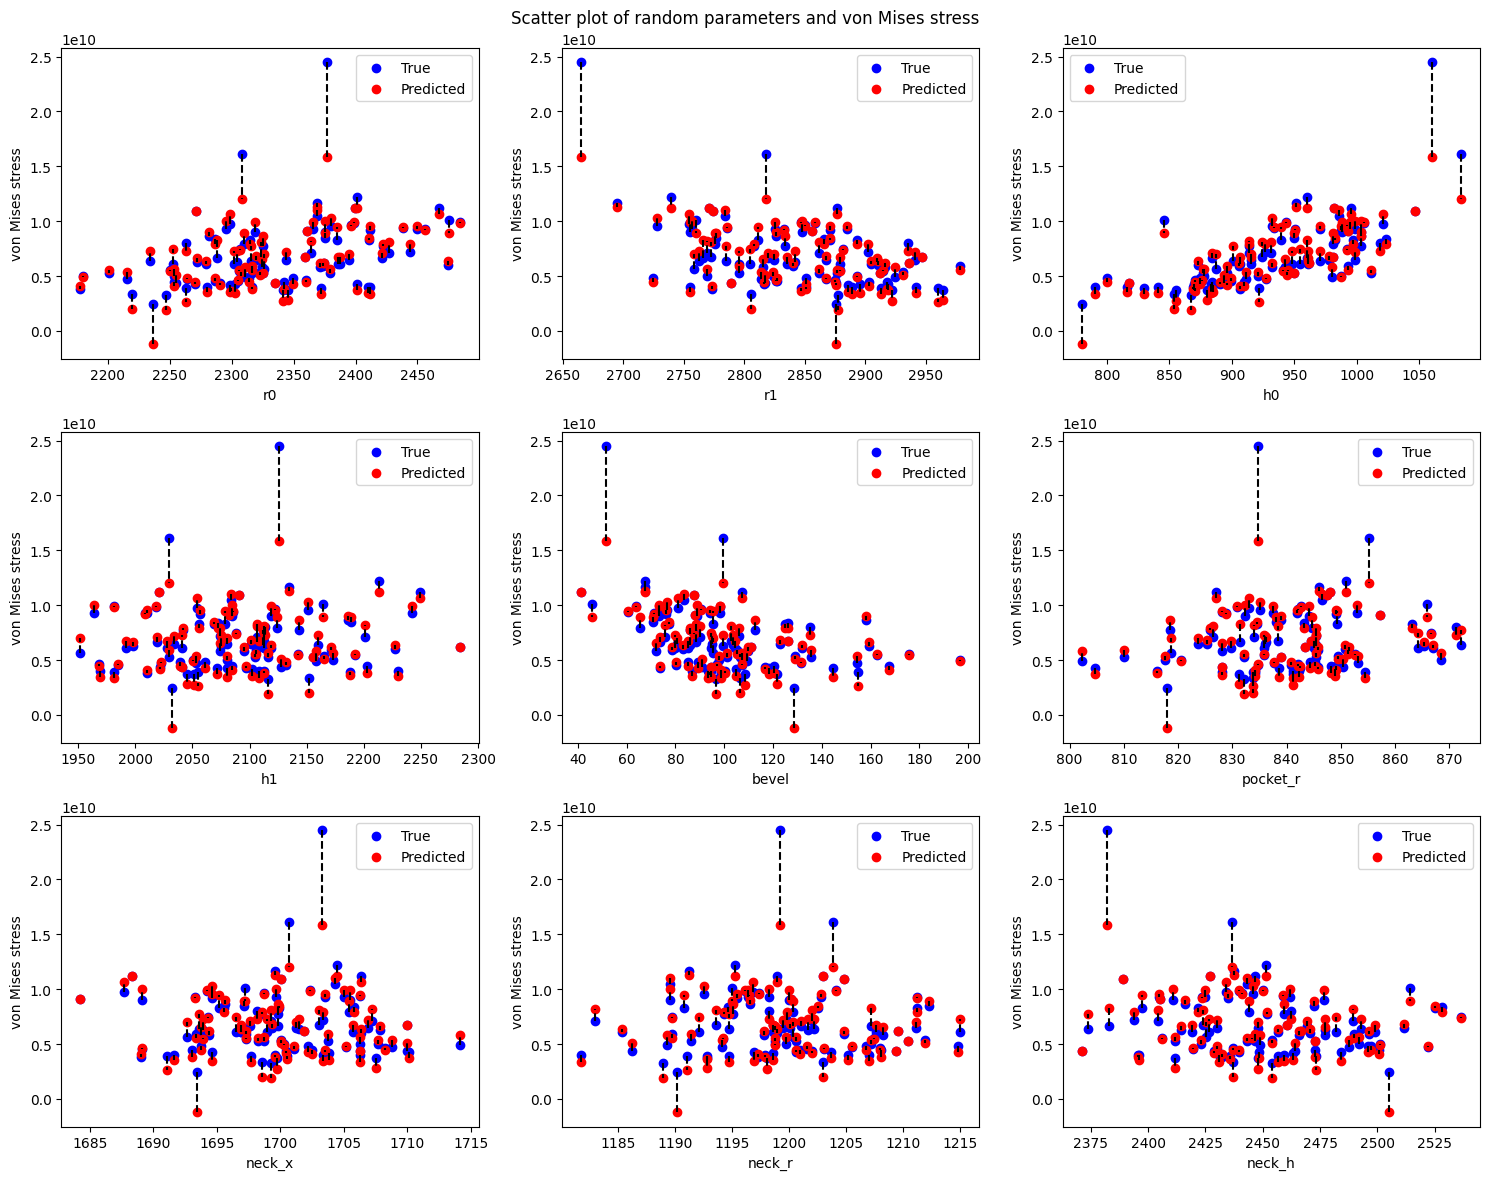

In [14]:
# 3x3のグリッドでプロットを作成
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, ax in enumerate(axes.flat):
    x = df.iloc[:,i] * 1e6
    ax.set_xlabel(df.columns[i])
    ax.set_ylabel('von Mises stress')
    ax.plot(np.vstack([x,x]), np.vstack([y,y_predict]), 'k--')
    ax.scatter(x, y, c='b', label='True')
    ax.scatter(x, y_predict, c='r', label='Predicted')
    ax.legend()

# タイトルと余白の調整
fig.suptitle('Scatter plot of random parameters and von Mises stress')
plt.tight_layout()
plt.show()

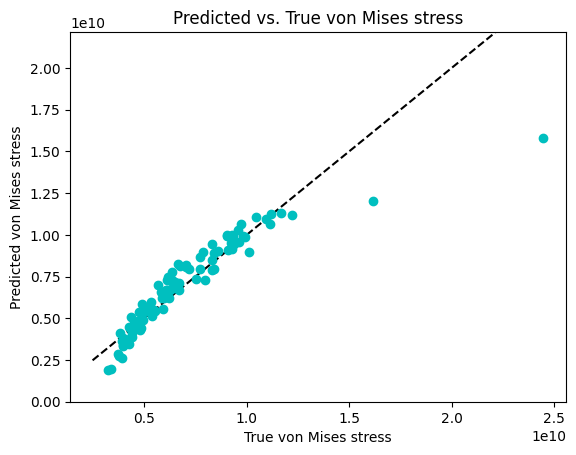

In [15]:
mises_sort = np.sort(y)
plt.plot(mises_sort, mises_sort, 'k--')
plt.plot(y, y_predict, 'co')
plt.title('Predicted vs. True von Mises stress')
plt.xlabel('True von Mises stress')
plt.ylabel('Predicted von Mises stress')
plt.ylim(0, 1.4 * np.max(y_predict))
plt.show()

In [24]:
import psutil

# システムのメモリ使用状況を取得
memory = psutil.virtual_memory()

# 総メモリ量
total_memory = memory.total / (1024**3)  # GB単位で変換
# 使用中のメモリ量
used_memory = memory.used / (1024**3)  # GB単位で変換
# 利用可能なメモリ量
available_memory = memory.available / (1024**3)  # GB単位で変換

print(f"総メモリ量: {total_memory:.2f} GB")
print(f"使用中のメモリ量: {used_memory:.2f} GB")
print(f"利用可能なメモリ量: {available_memory:.2f} GB")

総メモリ量: 8.00 GB
使用中のメモリ量: 3.39 GB
利用可能なメモリ量: 1.55 GB


In [17]:
mises_model = np.zeros([m, predicted_params.shape[0]])
x_model     = np.zeros([m, predicted_params.shape[0]])
y_model     = np.zeros([m, predicted_params.shape[0]])
z_model     = np.zeros([m, predicted_params.shape[0]])

model = LinearRegression(fit_intercept=False)
x = np.array(df.iloc[:,:])
x_with_bias = np.c_[x, np.ones(x.shape[0])]

for i in range(m):
    y = mises_array[:,i]
    model.fit(x_with_bias, y)
    mises_model[i] = model.coef_
    
    y = deform_array[:,i,0]
    model.fit(x_with_bias, y)
    x_model[i] = model.coef_
    
    y = deform_array[:,i,1]
    model.fit(x_with_bias, y)
    y_model[i] = model.coef_
    
    y = deform_array[:,i,2]
    model.fit(x_with_bias, y)
    z_model[i] = model.coef_
    

In [18]:
x.shape, x_with_bias.shape, mises_model.shape, x_model.shape, y_model.shape, z_model.shape

((100, 10), (100, 11), (9086, 11), (9086, 11), (9086, 11), (9086, 11))

In [19]:
mises_model

array([[ 2.09796678e+11, -1.91843726e+11,  9.45394404e+10, ...,
        -5.43099171e+10,  2.25652431e+11,  3.93854174e+08],
       [ 2.12393930e+11, -1.93099344e+11,  9.55662644e+10, ...,
        -5.86191379e+10,  2.27628056e+11,  3.93098814e+08],
       [ 2.10294852e+11, -1.91925360e+11,  9.63916245e+10, ...,
        -5.75353242e+10,  2.30823730e+11,  3.90335563e+08],
       ...,
       [ 1.32581072e+12, -1.03284596e+12,  4.38215354e+11, ...,
        -5.12869817e+10,  3.68438818e+11,  3.63644901e+09],
       [ 1.21448266e+12, -9.42274010e+11,  5.10779709e+11, ...,
        -7.56046555e+10,  3.22384206e+11,  3.63642389e+09],
       [ 1.34780587e+12, -1.06386850e+12,  5.28013793e+11, ...,
        -7.87701590e+10,  3.44980117e+11,  4.29634709e+09]])

In [20]:
np.savez('../data/train.npz', mises_model=mises_model, x_model=x_model, y_model=y_model, z_model=z_model)

In [21]:
models = np.load('../data/train.npz')

mises_model = models['mises_model']
x_model = models['x_model']
y_model = models['y_model']
z_model = models['z_model']


In [22]:
cp = [0,1,2,3,5,6,7,8]

# cp_with_bias = np.c_[np.array(cp), [1.0]]
cp_with_bias = np.hstack([np.array(cp), np.ones(1)])
cp_with_bias

array([0., 1., 2., 3., 5., 6., 7., 8., 1.])

In [25]:
import psutil

# システムのメモリ使用状況を取得
memory = psutil.virtual_memory()

# 総メモリ量
total_memory = memory.total / (1024**3)  # GB単位で変換
# 使用中のメモリ量
used_memory = memory.used / (1024**3)  # GB単位で変換
# 利用可能なメモリ量
available_memory = memory.available / (1024**3)  # GB単位で変換

print(f"総メモリ量: {total_memory:.2f} GB")
print(f"使用中のメモリ量: {used_memory:.2f} GB")
print(f"利用可能なメモリ量: {available_memory:.2f} GB")

総メモリ量: 8.00 GB
使用中のメモリ量: 3.33 GB
利用可能なメモリ量: 1.58 GB
